# Import the dataset

In [ ]:
# Install all the necessary libraries
!pip install numpy pandas matplotlib scipy sklearn imlearn

In [32]:
# Import all the necessary libraries

# Basic mathematical libs
import numpy as np
import pandas as pd

# Basic plotting libs
import matplotlib.pyplot as plt
import seaborn as sb
import scipy.stats as st

# Basic machine learning libs
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Table plotting enhancement libs
from tabulate import tabulate

# Basic libs to import libs from drive
from google.colab import drive
drive.mount('/content/drive')

# Filter all the unwanted warnings
import warnings
warnings.filterwarnings('ignore')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Define the new column names for easier access of columns
column_names=['not_filed_on_time', 'filed_on_time', 'average_tax_per_month', 'purchase_done_from_fraud', 'purchase_done_from_non_fraud', 'sales_done_fraud', 'sales_done_non_fraud', 'way_bill_purchase', 'way_bill_sale', 'AH', 'AN', 'status', 'false_negative_cost']

# Import the card-transactions dataset
df = pd.read_csv(
        filepath_or_buffer='/content/drive/My Drive/datasets/costsensitiveregression.csv',
        sep=',',
        header='infer',
        names=column_names,
        skiprows=1)

print(tabulate(df.head(), headers='keys', tablefmt='fancy_grid'))

╒════╤═════════════════════╤═════════════════╤═════════════════════════╤════════════════════════════╤════════════════════════════════╤════════════════════╤════════════════════════╤═════════════════════╤═════════════════╤══════╤══════╤══════════╤═══════════════════════╕
│    │   not_filed_on_time │   filed_on_time │   average_tax_per_month │   purchase_done_from_fraud │   purchase_done_from_non_fraud │   sales_done_fraud │   sales_done_non_fraud │   way_bill_purchase │   way_bill_sale │   AH │   AN │   status │   false_negative_cost │
╞════╪═════════════════════╪═════════════════╪═════════════════════════╪════════════════════════════╪════════════════════════════════╪════════════════════╪════════════════════════╪═════════════════════╪═════════════════╪══════╪══════╪══════════╪═══════════════════════╡
│  0 │                   2 │              21 │                       0 │                      0     │                              0 │                  0 │                      0 │          

# Get statistical measures of dataset

In [3]:
# Getting the insights of the data for further processing

# To get the size of the data
print('There are %d datapoints and %d features for the data' % df.shape)
print('\n', '-'*100, '\n')

# To get type summary of the numerical columns in df
print('Type Information values')
print(df.info())
print('\n', '-'*100, '\n')

# To get statistical summary of the numerical columns in df
print('Standard statistical values')
print(df.describe())
print('\n', '-'*100, '\n')

# To get the total count of nan values in each column
print('Count of nan values')
print(df.isna().sum())
print('\n', '-'*100, '\n')

# To get the total count of duplicate values in each column
print('Count of duplicate rows')
print(df.duplicated().sum())
print('\n', '-'*100, '\n')

There are 147636 datapoints and 13 features for the data

 ---------------------------------------------------------------------------------------------------- 

Type Information values
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147636 entries, 0 to 147635
Data columns (total 13 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   not_filed_on_time             147636 non-null  int64  
 1   filed_on_time                 147636 non-null  int64  
 2   average_tax_per_month         147636 non-null  float64
 3   purchase_done_from_fraud      147636 non-null  float64
 4   purchase_done_from_non_fraud  147636 non-null  float64
 5   sales_done_fraud              147636 non-null  float64
 6   sales_done_non_fraud          147636 non-null  float64
 7   way_bill_purchase             147636 non-null  float64
 8   way_bill_sale                 147636 non-null  float64
 9   AH                            147636 n

# Perform Exploratory Dataset Analysis

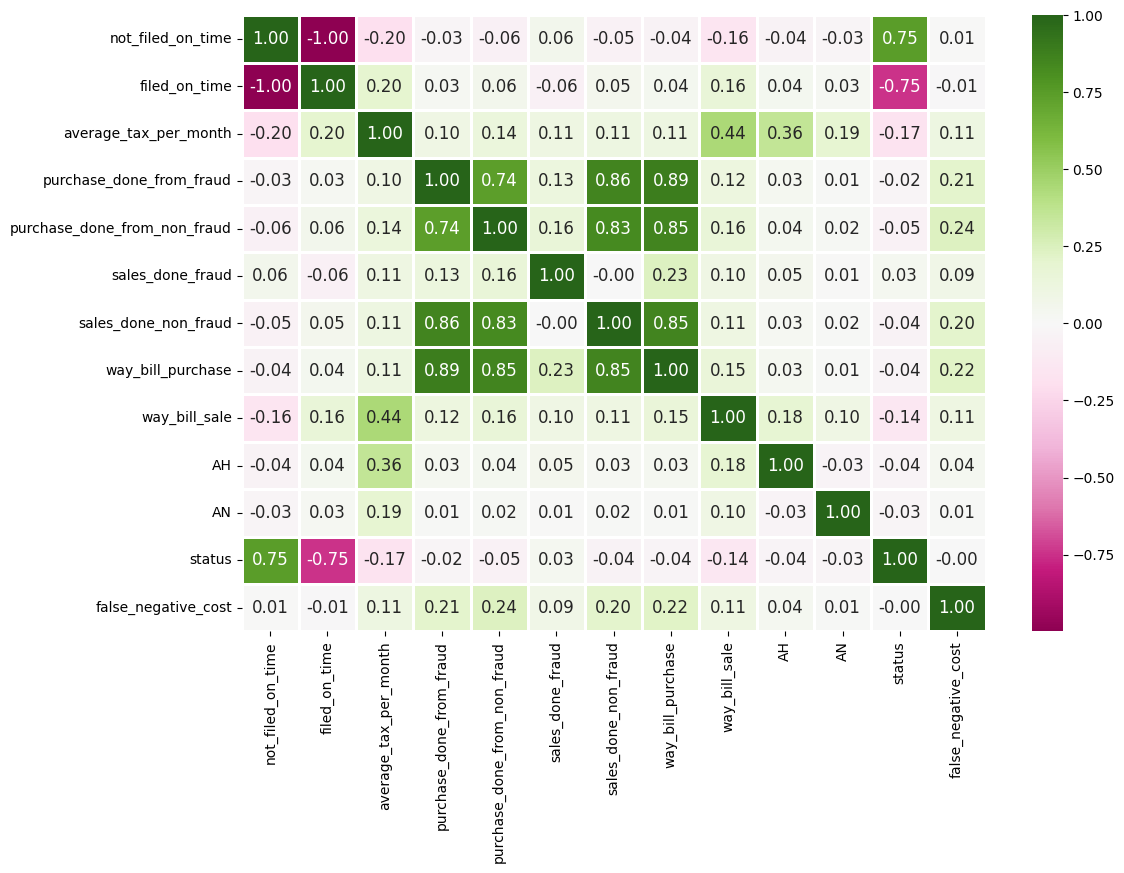

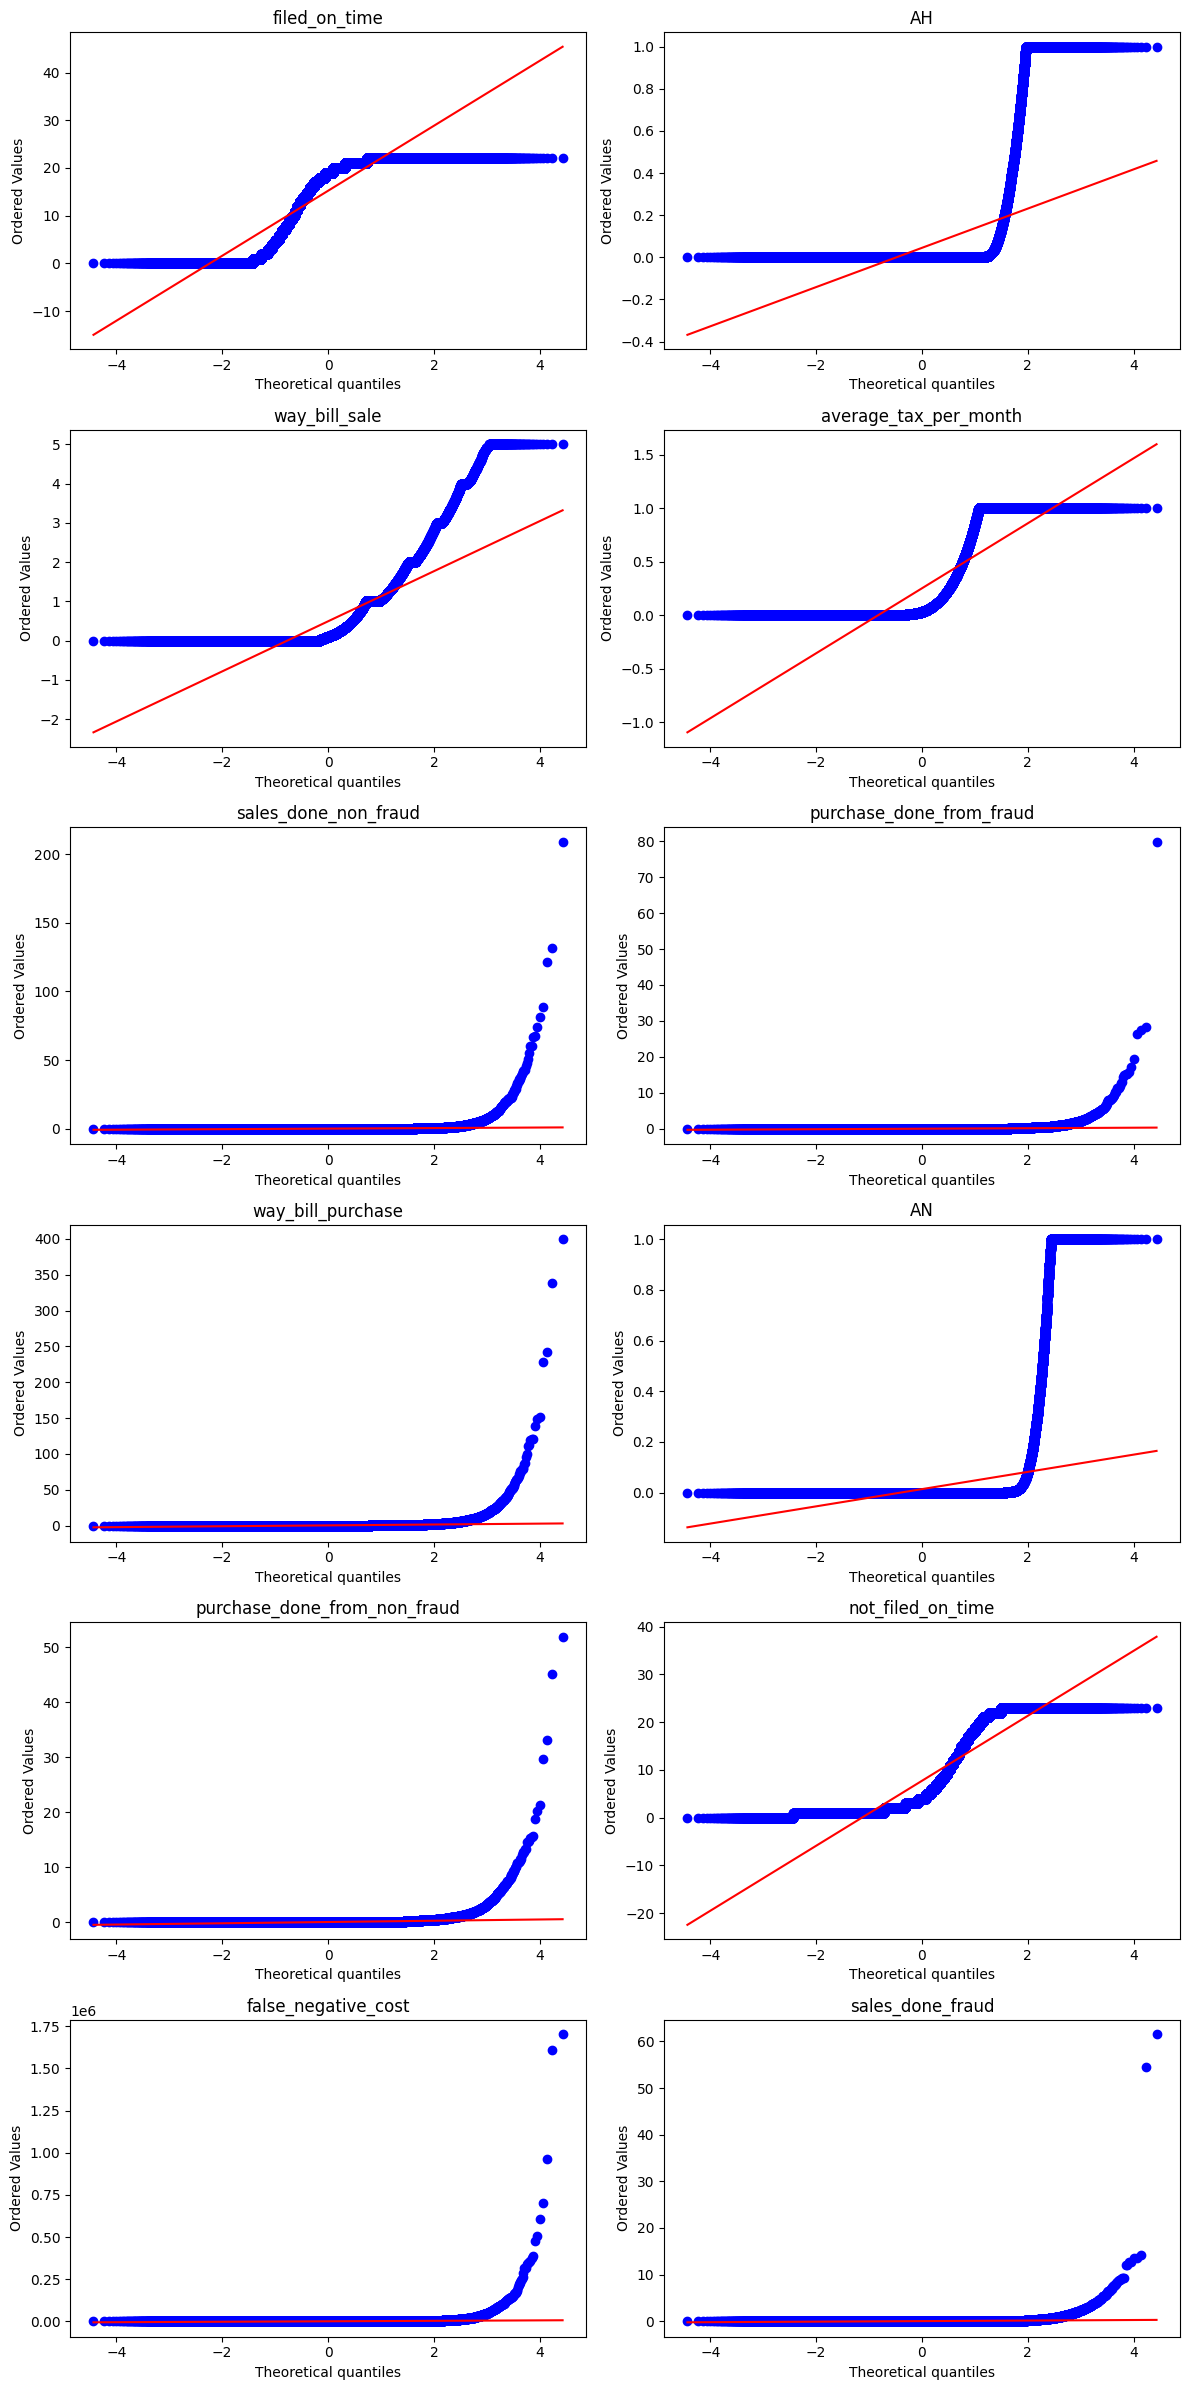

In [4]:
plt.figure(figsize=(12, 8))

# Display the correlation matrix bet various features
sb.heatmap(
    data=df.corr('pearson'),
    annot=True,
    annot_kws={'size': 12},
    fmt='.2f',
    cmap='PiYG',
    linewidths=2
)


# Observe the Q-Q plots for all features
cat_cols = set(df.drop(['status'], axis=1).columns)
num_cols = 2
num_rows = (len(cat_cols) + 1) // 2
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, num_rows * 4))
if len(cat_cols) > 1:
    axes = axes.flatten()
for i, col in enumerate(cat_cols):
    ax = axes[i]
    st.probplot(df[col], dist='norm', plot=ax)
    ax.set_title(col)
for i in range(len(cat_cols), len(axes)):
    fig.delaxes(axes[i])
plt.tight_layout()
plt.show()


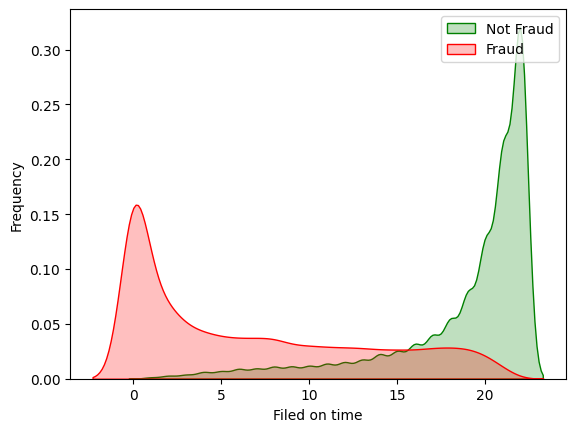

In [5]:

# Observe the different status when filed_on_time
fig = sb.kdeplot(df['filed_on_time'][(df['status'] == 0) & (df['filed_on_time'].notnull())],
    color='green',
    shade=True,
)
fig = sb.kdeplot(df['filed_on_time'][(df['status'] == 1) & (df['filed_on_time'].notnull())],
    ax=fig,
    color='red',
    shade=True,
)
fig.set_xlabel('Filed on time')
fig.set_ylabel('Frequency')
fig = fig.legend(['Not Fraud', 'Fraud'])

**Observations for the card-transactions dataset**

1. Highly +ve correlated-features

    a. not_filed_on_time & status

    b. purchase_done_from_fraud & way_bill_purchase

    c. purchase_done_from_non_fraud & way_bill_purchase

2. Highly -ve correlated-features

    a. filed_on_time & status

3. Most of the columns does not follow normal distributions hence we mmust perform MinMax transform before training.

4. There are no null values but have duplicate values, hence we must remove them.


# Perform Preprocessing of dataset

In [6]:
# Perform some operations on dataset to get it ready to implement model
def preprocess_data_cost_sensitive(df):

    # Handle the duplicate rows
    df = df.drop_duplicates() # drop duplicate rows
    df.reset_index(drop=True, inplace=True) # reset the index
    return df

preprocessing_pipeline = Pipeline([
    ('cleaning', FunctionTransformer(preprocess_data_cost_sensitive, validate=False)),
], verbose=True)

df = preprocessing_pipeline.fit_transform(df)

[Pipeline] .......... (step 1 of 1) Processing cleaning, total=   0.1s


# Generate training and testing dataset and cost matrix

In [7]:
# Generate the cost-sensitive cost-matrix with TP, FP, TN & FN for Complete Dataset
cost_matrix = np.zeros((df.shape[0], 4))
cost_matrix[:, 0] = 6
cost_matrix[:, 1] = 6
cost_matrix[:, 2] = 0
cost_matrix[:, 3] = df['false_negative_cost']

In [8]:
# Training Algorithm parameters (Genetic Algorithm is used as some loss functions are not convex in nature)
population_size = 50
mutation_rate = 0.01
num_generations = 100

In [9]:
# Split the Data in Training and Testing sets
features = df.drop(['status', 'false_negative_cost'], axis=1)
labels = df['status']
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

In [10]:
# Generate the cost-sensitive cost-matrix with TP, FP, TN & FN for X_train
indices_for_X_train = X_train.index
cost_matrix_X_train = cost_matrix[indices_for_X_train]

# Generate the cost-sensitive cost-matrix with TP, FP, TN & FN for X_test
indices_for_X_test = X_test.index
cost_matrix_X_test = cost_matrix[indices_for_X_test]

In [11]:
# Perform Standard Scaling to DataFrame
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Main Genetic Algorithm

In [62]:
# Main Algorithm Starts here
class GeneticAlgorithmDefault:

    def __init__(self, population_size=100, mutation_rate=0.01, num_generations=1000):
        self.population_size = population_size
        self.mutation_rate = mutation_rate
        self.num_generations = num_generations
        self.weights_=None
        self.losses_=[]

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def logistic_loss(self, y_true, y_pred, cost_matrix):
        return-np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

    def logistic_regression(self, theta, X):
        return self.sigmoid(np.dot(X, theta))

    def cost_function(self, theta, X, y, cost_matrix):
        predictions = self.logistic_regression(theta, X)
        loss = self.logistic_loss(y, predictions, cost_matrix)
        self.losses_.append(loss)
        return loss

    def fit(self, X, y, cost_matrix):

        # Add the bias to the training-data
        X = np.concatenate((np.ones((X.shape[0], 1)), X_train), axis=1)  # Add bias term

        num_features = X.shape[1]

        # Random initialization of Population parameters
        population = np.random.rand(self.population_size, num_features)

        # Main loop
        for generation in range(self.num_generations):

            # Evaluate fitness of each individual
            fitness_scores = np.array([self.cost_function(theta, X, y, cost_matrix) for theta in population])

            # Selection
            selected_indices = np.random.choice(self.population_size, size=self.population_size, replace=True, p=fitness_scores / np.sum(fitness_scores))
            selected_individuals = population[selected_indices]

            # Crossover
            offspring = []
            for _ in range(self.population_size):
                parent_indices = np.random.choice(self.population_size, size=2, replace=False)
                parent1, parent2 = selected_individuals[parent_indices]
                crossover_point = np.random.randint(1, num_features)  # Perform one-point crossover
                child = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
                offspring.append(child)

            # Mutation
            for i in range(self.population_size):
                if np.random.rand() < self.mutation_rate:
                    mutation_index = np.random.randint(num_features)
                    offspring[i][mutation_index] += np.random.normal(0, 0.1)  # Add small random noise

            # Replacement: Replace current population with offspring
            population = np.array(offspring)

        # After convergence, select the best individual as the solution
        best_individual_index = np.argmin([self.cost_function(theta, X, y, cost_matrix) for theta in population])
        best_individual = population[best_individual_index]
        self.weights_=np.array(best_individual)

    def predict(self, X):
        X = np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)  # Add bias term
        predictions = self.logistic_regression(self.weights_, X)
        predictions = (predictions >= 0.9).astype(int) # set the threshold to 0.9
        return predictions


In [63]:
cost_matrix_default_train = np.ones((X_train.shape[0], 4))
cost_matrix_default_test = np.ones((X_test.shape[0], 4))

gen_normal = GeneticAlgorithmDefault(population_size, mutation_rate, num_generations)
gen_normal.fit(X_train, y_train, cost_matrix_default_train)
y_pred_normal = gen_normal.predict(X_test)

# Bahnsen Algorithm

In [64]:
# Bahnsen Algorithm
class GeneticAlgorithmBahnsen(GeneticAlgorithmDefault):

    def __init__(self, population_size=100, mutation_rate=0.01, num_generations=1000):
        super().__init__(population_size, mutation_rate, num_generations)

    def logistic_loss(self, y_true, y_pred, cost_matrix):
        TP = cost_matrix[:, 0]
        FP = cost_matrix[:, 1]
        TN = cost_matrix[:, 2]
        FN = cost_matrix[:, 3]

        val = np.mean(y_true * (y_pred * TP + (1 - y_pred) * FN) + (1 - y_true) * (y_pred * FP + (1 - y_pred) * TN))
        return val


gen_bhansen = GeneticAlgorithmBahnsen(population_size, mutation_rate, num_generations)
gen_bhansen.fit(X_train, y_train, cost_matrix_X_train)
y_pred_bahnsen = gen_bhansen.predict(X_test)

# Nikou-Gunnemann Algorithm

In [65]:
# NikouGunnemann Algorithm
class GeneticAlgorithmNikouGunnemann(GeneticAlgorithmDefault):

    def __init__(self, population_size=100, mutation_rate=0.01, num_generations=1000):
        super().__init__(population_size, mutation_rate, num_generations)

    def logistic_loss(self, y_true, y_pred, cost_matrix):

        # Variant A
        a = cost_matrix[:, 3]
        b = np.ones(cost_matrix.shape[0])

        val= -np.mean(a * y_true * np.log(y_pred ** b) + a * (1 - y_true) * np.log(1 - y_pred ** b)) * y_pred.shape[0]

        return val


gen_nikou = GeneticAlgorithmNikouGunnemann(population_size, mutation_rate, num_generations)
gen_nikou.fit(X_train, y_train, cost_matrix_X_train)
y_pred_nikou = gen_nikou.predict(X_test)

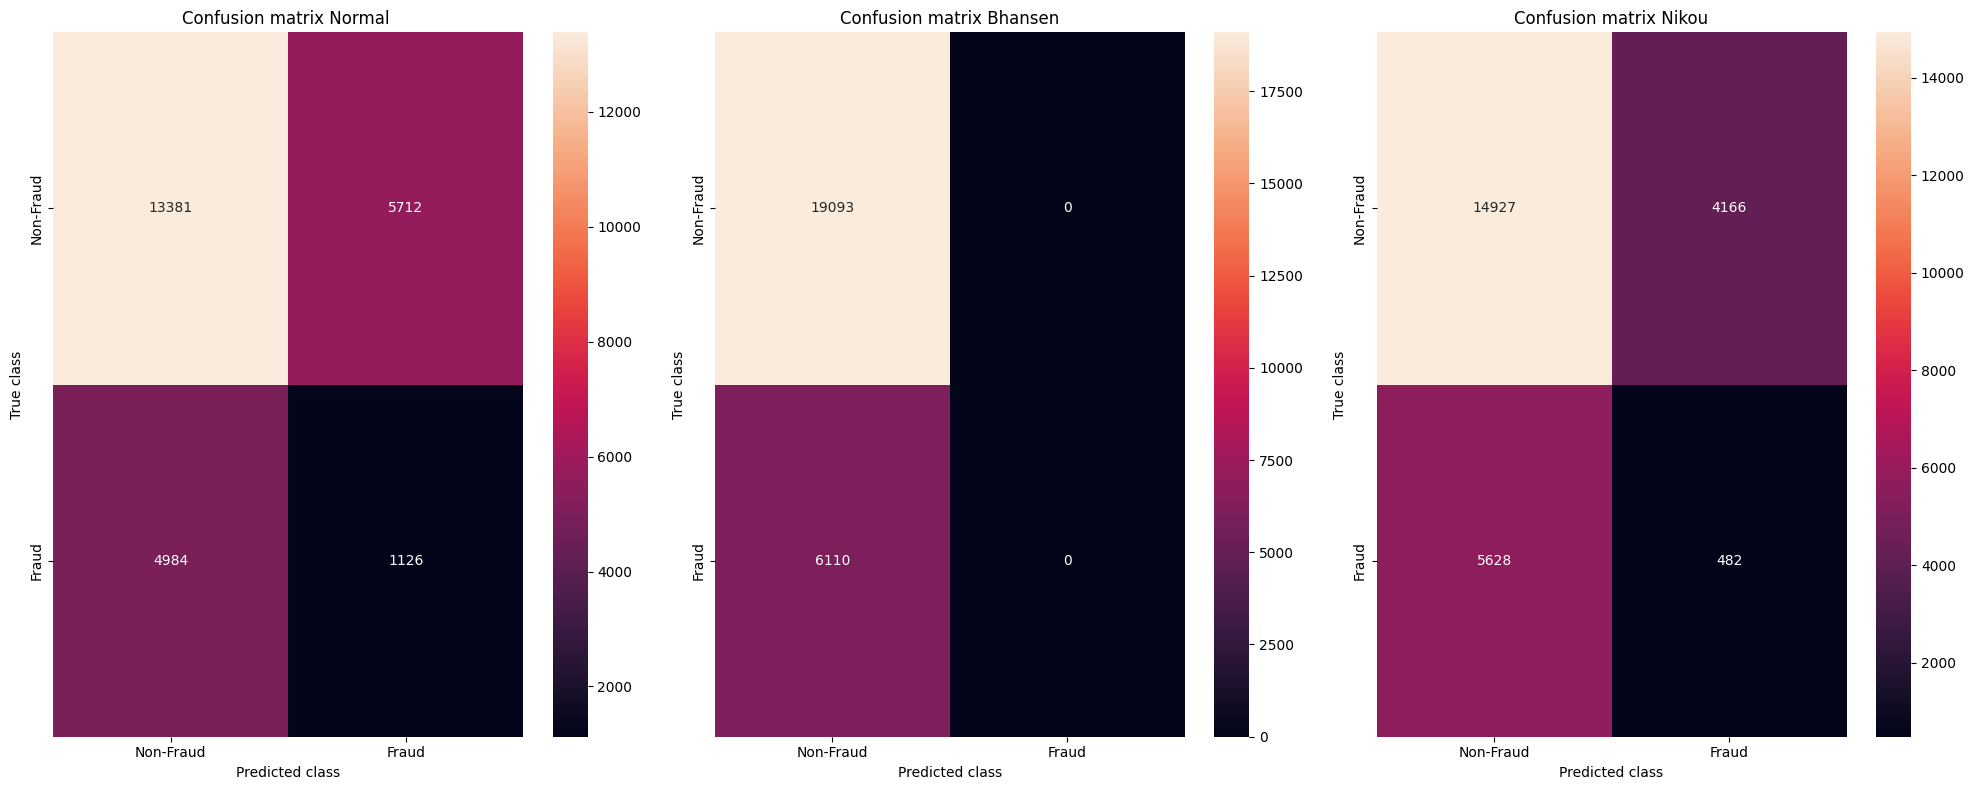

In [66]:
plt.figure(figsize=(20, 8))
labels=['Non-Fraud','Fraud']
# From the above figures we select the thresholds for the fraud Vs no-fraud transactions

# Plot for Normal
conf_matrix = confusion_matrix(y_test, y_pred_normal)

plt.subplot(1, 3, 1)
sb.heatmap(conf_matrix, xticklabels=labels, yticklabels=labels, annot=True, fmt="d");
plt.title('Confusion matrix Normal ')
plt.ylabel('True class')
plt.xlabel('Predicted class')

# Plot for Bhansen
conf_matrix = confusion_matrix(y_test, y_pred_bahnsen)

plt.subplot(1, 3, 2)
sb.heatmap(conf_matrix, xticklabels=labels, yticklabels=labels, annot=True, fmt="d");
plt.title('Confusion matrix Bhansen')
plt.ylabel('True class')
plt.xlabel('Predicted class')

# Plot for Nikou
conf_matrix = confusion_matrix(y_test, y_pred_nikou)

plt.subplot(1, 3, 3)
sb.heatmap(conf_matrix, xticklabels=labels, yticklabels=labels, annot=True, fmt="d");
plt.title('Confusion matrix Nikou')
plt.ylabel('True class')
plt.xlabel('Predicted class')

plt.tight_layout()
plt.show()

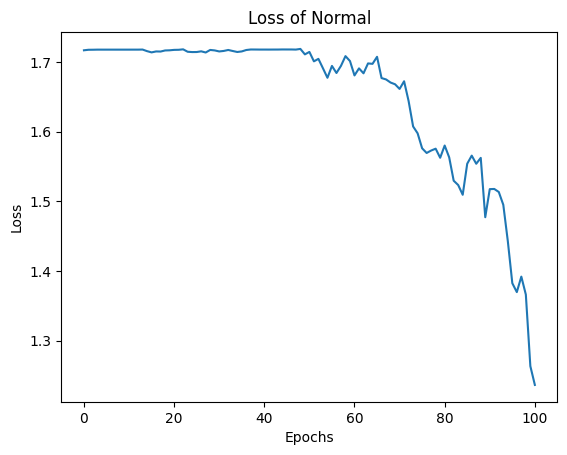

In [81]:
def average_at_regular_interval(arr, interval=10):
    return list(map(lambda i: sum(arr[i:i+interval])/interval, range(0, len(arr), interval)))[::-1]

# Plotting the array as a line plot
plt.plot(average_at_regular_interval(gen_normal.losses_, 50))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss of Normal')
plt.show()

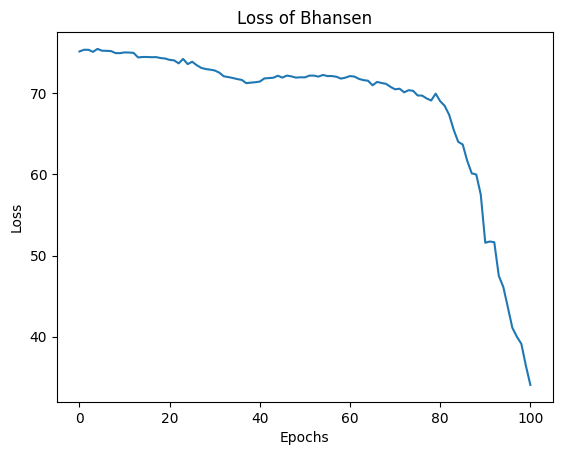

In [84]:
# Plotting the array as a line plot
plt.plot(average_at_regular_interval(gen_bhansen.losses_, 50))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss of Bhansen')
plt.show()

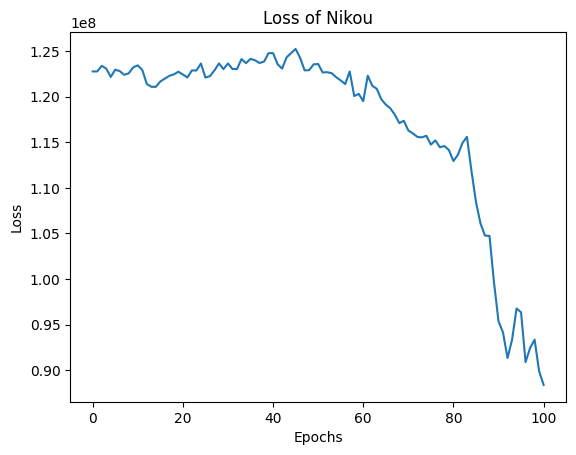

In [85]:
# Plotting the array as a line plot
plt.plot(average_at_regular_interval(gen_nikou.losses_, 50))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss of Nikou')
plt.show()

In [67]:
# Accuracy for the Normal
print('Accuracy for normal')
print(accuracy_score(y_test, y_pred_normal))

print('--'*25)

# Accuracy for the Bhansen
print('Accuracy for Bhansen')
print(accuracy_score(y_test, y_pred_bahnsen))

print('--'*25)

# Accuracy for the Nikou
print('Accuracy for Nikou')
print(accuracy_score(y_test, y_pred_nikou))

Accuracy for normal
0.5756060786414315
--------------------------------------------------
Accuracy for Bhansen
0.7575685434273698
--------------------------------------------------
Accuracy for Nikou
0.6113954687933976


In [72]:

def calculate_cost_score(a, y_true, y_pred):
    return np.sum(a * (y_pred != y_true))

# Cost Score for the Normal
print('Cost Score for normal')
print(calculate_cost_score(cost_matrix_default_test[:, 3], y_test, y_pred_normal))

print('--'*25)

# Cost Score for the Bhansen
print('Cost Score for Bhansen')
print(calculate_cost_score(cost_matrix_X_test[:, 3], y_test, y_pred_bahnsen))

print('--'*25)

# Cost Score for the Nikou
print('Cost Score for Nikou')
print(calculate_cost_score(cost_matrix_X_test[:, 3], y_test, y_pred_nikou))


Cost Score for normal
10696.0
--------------------------------------------------
Cost Score for Bhansen
4566953.395484
--------------------------------------------------
Cost Score for Nikou
14016355.621456001


In [68]:
# Report for the Normal
print('Classification Report for the Normal \n')
print(classification_report(y_test, y_pred_normal))

print('--'*25)

# Report for the Bhansen
print('Classification Report for the Bhansen \n')
print(classification_report(y_test, y_pred_bahnsen))

print('--'*25)

# Report for the Nikou
print('Classification Report for the Nikou \n')
print(classification_report(y_test, y_pred_nikou))

Classification Report for the Normal 

              precision    recall  f1-score   support

           0       0.73      0.70      0.71     19093
           1       0.16      0.18      0.17      6110

    accuracy                           0.58     25203
   macro avg       0.45      0.44      0.44     25203
weighted avg       0.59      0.58      0.58     25203

--------------------------------------------------
Classification Report for the Bhansen 

              precision    recall  f1-score   support

           0       0.76      1.00      0.86     19093
           1       0.00      0.00      0.00      6110

    accuracy                           0.76     25203
   macro avg       0.38      0.50      0.43     25203
weighted avg       0.57      0.76      0.65     25203

--------------------------------------------------
Classification Report for the Nikou 

              precision    recall  f1-score   support

           0       0.73      0.78      0.75     19093
           1      